# Doubly-robust estimation with a causal latent factor model

This notebook is an attempt to reproduce the synthetic data experiment in section 6 of [Doubly Robust Inference in Causal Latent Factor Models](https://arxiv.org/abs/2402.11652) using the MC-EIF one-step corrected estimator described in [Automated Efficient Estimation using Monte Carlo Efficient Influence Functions](https://arxiv.org/abs/2403.00158) and implemented in `chirho.robust`.

In [26]:
%load_ext autoreload
%autoreload 2

from typing import Callable, Mapping, TypedDict

import torch

import pyro
import pyro.distributions as dist

import chirho
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.estimators import one_step_corrected_estimator
from chirho.robust.handlers.predictive import BatchedLatents, PredictiveModel

pyro.set_rng_seed(101)
pyro.settings.set(module_local_params=True)

## Introduction: causal effect estimation with missing data and multiple measurements

![Figure1](figures/dr_matcomp.png)

The above image is Figure 1 from the source paper [Doubly Robust Inference in Causal Latent Factor Models](https://arxiv.org/abs/2402.11652)

## Model: low-rank linear latent factor model

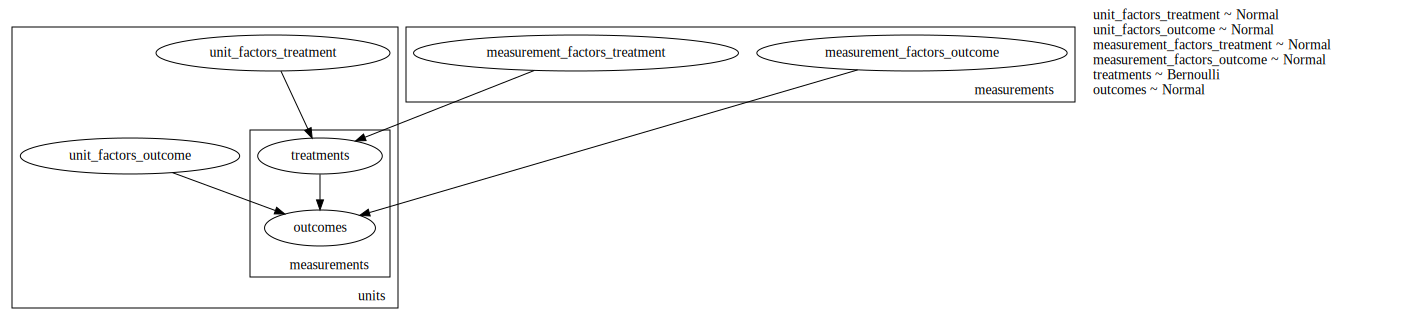

In [9]:
class FactorModel(pyro.nn.PyroModule):
    num_units: int
    num_measurements: int
    num_factors: int

    def __init__(self, num_units: int, num_measurements: int, num_factors: int):
        super().__init__()
        self.num_units = num_units
        self.num_measurements = num_measurements
        self.num_factors = num_factors
        self.unit_plate = pyro.plate("units", self.num_units, dim=-2)
        self.measurement_plate = pyro.plate("measurements", self.num_measurements, dim=-1)
        self.register_buffer("zero", torch.tensor(0.))
        self.register_buffer("one", torch.tensor(1.))

    @property
    def unit_factors_treatment_prior(self) -> dist.Distribution:
        return dist.Normal(self.zero, self.one).expand([self.num_factors]).to_event(1)

    @property
    def unit_factors_outcome_prior(self) -> dist.Distribution:
        return dist.Normal(self.zero, self.one).expand([self.num_factors, 2]).to_event(2)

    @property
    def measurement_factors_treatment_prior(self) -> dist.Distribution:
        return dist.Normal(self.zero, self.one).expand([self.num_factors]).to_event(1)

    @property
    def measurement_factors_outcome_prior(self) -> dist.Distribution:
        return dist.Normal(self.zero, self.one).expand([self.num_factors, 2]).to_event(2)

    def outcome_link_fn(self, outcome_locs: torch.Tensor) -> dist.Distribution:
        return dist.Normal(outcome_locs, self.one)

    def forward(self) -> torch.Tensor:
        with self.unit_plate:
            unit_factors_treatment = pyro.sample("unit_factors_treatment", self.unit_factors_treatment_prior)
            unit_factors_outcome = pyro.sample("unit_factors_outcome", self.unit_factors_outcome_prior)

        with self.measurement_plate:
            measurement_factors_treatment = pyro.sample("measurement_factors_treatment", self.measurement_factors_treatment_prior)
            measurement_factors_outcome = pyro.sample("measurement_factors_outcome", self.measurement_factors_outcome_prior)

        treatment_logits = torch.einsum("...umk,...mk->...um", unit_factors_treatment, measurement_factors_treatment)
        potential_outcome_locs = torch.einsum("...umkt,...mkt->...umt", unit_factors_outcome, measurement_factors_outcome)
        with self.unit_plate, self.measurement_plate:
            treatments = pyro.sample("treatments", dist.Bernoulli(logits=treatment_logits))
            outcome_locs = torch.where(treatments == 0, potential_outcome_locs[..., 0], potential_outcome_locs[..., 1])
            outcomes = pyro.sample("outcomes", self.outcome_link_fn(outcome_locs))
            return outcomes

model = FactorModel(
    num_units=100,
    num_measurements=10,
    num_factors=3,
)

pyro.render_model(model, render_deterministic=True, render_distributions=True, render_params=True)

## Data: synthetic data-generating process

In [ ]:
class TrueModel(FactorModel):
    def __init__(self):
        super().__init__(num_units=100, num_measurements=10, num_factors=3)

true_model = TrueModel()

class FactorModelDataset(TypedDict):
    treatments: torch.Tensor
    outcomes: torch.Tensor

true_dgp: Callable[[], FactorModelDataset] = pyro.infer.Predictive(true_model, return_sites=["treatments", "outcomes"], num_samples=2)

# generate full datasets
train_data: FactorModelDataset = true_dgp()
test_data: FactorModelDataset = true_dgp()

# TODO generate missingness masks and apply them to the datasets?

## Parameter estimation: maximum a posteriori inference (MAP)

In [13]:
class ConditionedFactorModel(pyro.nn.PyroModule):
    model: FactorModel

    def __init__(self, model: FactorModel):
        super().__init__()
        self.model = model

    def forward(self, data: FactorModelDataset) -> torch.Tensor:
        with condition(data=data):
            return self.model()

conditioned_model = ConditionedFactorModel(model)
guide = pyro.infer.autoguide.AutoDelta(conditioned_model)

elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide)

elbo(train_data)  # initialize guide

optim = torch.optim.Adam(elbo.parameters(), lr=0.01)

for step in range(1001):
    optim.zero_grad()
    loss = elbo(train_data)
    loss.backward()
    optim.step()
    if step % 100 == 0:
        print(f"step {step} loss = {loss.item()}")

/home/eli/development/pyro/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'units', 'measurements'}
  warnings.warn(


step 0 loss = 5191.841796875
step 100 loss = 3312.970947265625
step 200 loss = 2895.181396484375
step 300 loss = 2801.5830078125
step 400 loss = 2778.109375
step 500 loss = 2761.412841796875
step 600 loss = 2744.73876953125
step 700 loss = 2739.44775390625
step 800 loss = 2737.70654296875
step 900 loss = 2737.019775390625
step 1000 loss = 2736.730712890625


## Query: average treatment effect (ATE)

In [37]:
class ATEFunctional(pyro.nn.PyroModule):
    model: FactorModel
    num_samples: int

    def __init__(self, model: FactorModel, *, num_samples: int = 10):
        super().__init__()
        self.model = model
        self.num_samples = num_samples
        self.register_buffer("zero", torch.tensor(0.))
        self.register_buffer("one", torch.tensor(1.))

    def forward(self) -> torch.Tensor:
        with MultiWorldCounterfactual() as mwc:
            with BatchedLatents(num_particles=self.num_samples):
                with do(actions=dict(treatments=(self.zero, self.one))):
                    outcomes = self.model()

                outcomes_treated = gather(outcomes, IndexSet(treatments={2}))
                outcomes_untreated = gather(outcomes, IndexSet(treatments={1}))
                ites = outcomes_treated - outcomes_untreated
                return pyro.deterministic("ate", ites.mean((-1, -2)))

target_functional = lambda m: ATEFunctional(m, num_samples=10)
predictive_model: PredictiveModel[[], torch.Tensor] = PredictiveModel(model, guide)

### Plug-in estimator

In [38]:
plugin_estimator: Callable[[], torch.Tensor] = target_functional(predictive_model)
plugin_estimator()

tensor([[[[-0.0564]],

         [[-0.0566]],

         [[-0.0057]],

         [[-0.0647]],

         [[-0.0040]],

         [[-0.0571]],

         [[-0.1214]],

         [[-0.0126]],

         [[-0.0505]],

         [[-0.0719]]]], grad_fn=<MeanBackward1>)

### One-step corrected estimator

In [39]:
dr_estimator: Callable[[], torch.Tensor] = one_step_corrected_estimator(target_functional, test_data, num_samples_outer=101)(predictive_model)
dr_estimator()

RuntimeError: shape '[101, 100, 10]' is invalid for input of size 10201000